<a href="https://colab.research.google.com/github/phonhay103/anything/blob/main/class_activation_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete7COMGW/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
def preprocessing(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255
    image = tf.image.resize(image, (300, 300))
    label = tf.cast(label, tf.int32)
    return image, label

In [4]:
train_ds = train_data.map(preprocessing).shuffle(1000).batch(32)
validation_ds = validation_data.map(preprocessing).shuffle(1000).batch(32)
test_ds = test_data.map(preprocessing).batch(1)

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile('adam', 'binary_crossentropy', ['acc'])
model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds
)

Epoch 1/10
582/582 [==============================] - 69s 114ms/step - loss: 0.6133 - acc: 0.6579 - val_loss: 0.5945 - val_acc: 0.6819
Epoch 2/10
582/582 [==============================] - 67s 112ms/step - loss: 0.5883 - acc: 0.6882 - val_loss: 0.5828 - val_acc: 0.7016
Epoch 3/10
582/582 [==============================] - 67s 112ms/step - loss: 0.5677 - acc: 0.7063 - val_loss: 0.5613 - val_acc: 0.7120
Epoch 4/10
582/582 [==============================] - 67s 112ms/step - loss: 0.5544 - acc: 0.7195 - val_loss: 0.5580 - val_acc: 0.7261
Epoch 5/10
582/582 [==============================] - 67s 113ms/step - loss: 0.5443 - acc: 0.7309 - val_loss: 0.5432 - val_acc: 0.7322
Epoch 6/10
582/582 [==============================] - 67s 113ms/step - loss: 0.5240 - acc: 0.7448 - val_loss: 0.5194 - val_acc: 0.7584
Epoch 7/10
582/582 [==============================] - 67s 113ms/step - loss: 0.5052 - acc: 0.7572 - val_loss: 0.5147 - val_acc: 0.7584
Epoch 8/10
582/582 [==============================] - 6

In [34]:
gap_weights = model.layers[-1].get_weights()[0]
features_shape = model.layers[-3].output_shape
cam_model  = tf.keras.Model(inputs=model.input, outputs=(model.layers[-3].output, model.layers[-1].output))

In [42]:
features_shape, model.layers[-1].output_shape, gap_weights.shape

((None, 37, 37, 128), (None, 1), (128, 1))

In [43]:
def show_cam_image(image, features, label):
    '''
    Displays the class activation map of an image

    Args:
    image_value (tensor) -- preprocessed input image
    features (array) -- features of the image
    results (array) -- output of the sigmoid layer
    '''

    features = features[0]
    prediction = label[0]
    class_activation_weights = gap_weights[:, 0]

    # upsample to the image size
    class_activation_features = sp.ndimage.zoom(features, (image.shape[1]/features_shape[1], image.shape[2]/features_shape[2], 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features, class_activation_weights)

    # visualize the results
    print(f'sigmoid output: {label[0][0]}')
    print(f"prediction: {'dog' if round(label[0][0]) else 'cat'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image), alpha=0.5)
    plt.show()

ground truth: cat
sigmoid output: 0.3336232900619507
prediction: cat


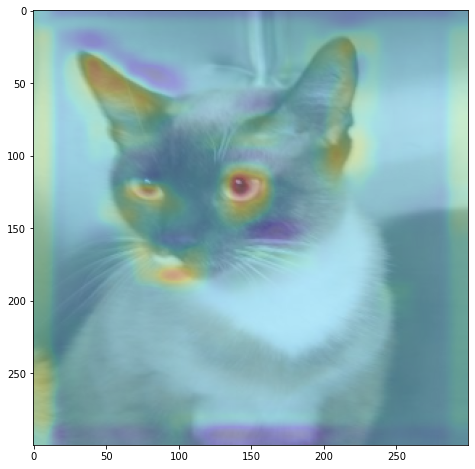

ground truth: dog
sigmoid output: 0.38060519099235535
prediction: cat


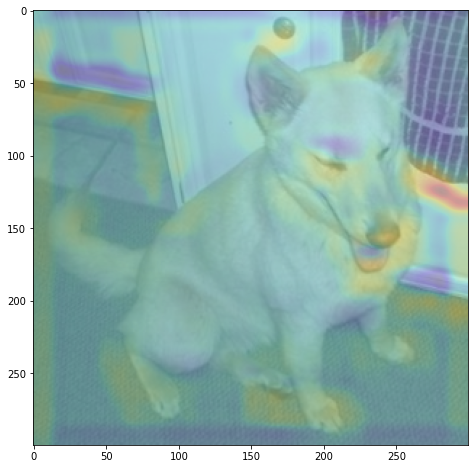

ground truth: dog
sigmoid output: 0.4042758643627167
prediction: cat


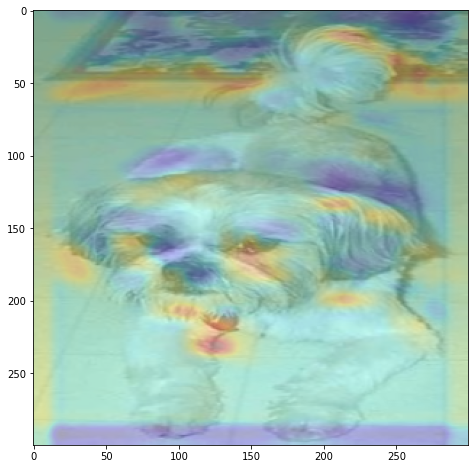

ground truth: cat
sigmoid output: 0.1274598389863968
prediction: cat


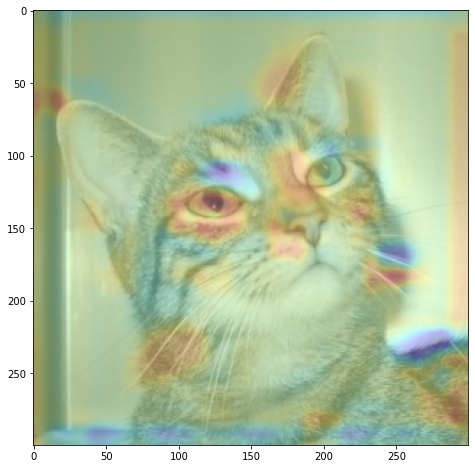

ground truth: cat
sigmoid output: 0.3506866991519928
prediction: cat


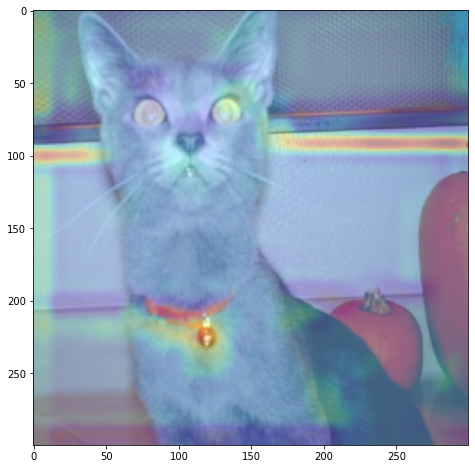

In [44]:
for img, lbl in test_ds.take(5):
    print(f"ground truth: {'dog' if lbl else 'cat'}")
    features, label = cam_model.predict(img)
    show_cam_image(img, features, label)